In [34]:
import numpy as np
import pandas as pd
import itertools
import random
from tqdm import tqdm
from ast import literal_eval
import time

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import joblib
device = torch.device("cpu")

import matplotlib.pyplot as plt

In [35]:
plt.style.use('seaborn-v0_8')
plt.rcParams["grid.linestyle"] = "--"

plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.shadow'] = True
plt.rcParams['legend.facecolor'] = "lavender"

In [36]:
config_dict_1 = {
    0: "fair",
    1: "cheat-1_no-cooldown",
    2: "cheat-2_no-dash",
    3: "cheat-3_inf-slowmo",
    4: "cheat-4_huge-damage",
    5: "cheat-5_frozen-ninja",
}

config_dict_2 = {
    0: "fair_new",
    1: "cheat-1_new",
    2: "cheat-2_new",
    3: "cheat-3_new",
    4: "cheat-4_new",
    5: "cheat-5_new",
}

In [37]:
def preprocess_gt_csv(data_name):
    filename = f"train_data/gt/{data_name}.csv"

    columns_to_eval = [
        "global_mouse_position",
        "button_cooldown_times",
        "logical_frames_since_last_button_press",
        "global_position",
        "velocity",
        "fruits_cut_this_frame_list",
        "fruits_hit_ninjas_ass_this_frame_list",
        "fruits_on_screen_this_frame_list",
        "fruits_spawned_this_frame_list",
        "stupid_fucking_fruits_that_died_this_frame_list",
    ]

    df = pd.read_csv(filename, converters={column: literal_eval for column in columns_to_eval})

    df["fruits_spawned_num"] = df["fruits_spawned_this_frame_list"].str.len()
    df["fruits_on_screen_num"] = df["fruits_on_screen_this_frame_list"].str.len()
    df["fruits_hit_num"] = df["fruits_hit_ninjas_ass_this_frame_list"].str.len()
    df["fruits_missed_num"] = df["stupid_fucking_fruits_that_died_this_frame_list"].str.len()

    projectiles = ["Apple", "Banana", "Grape", "Pineapple", "Watermelon", "Coconut", "Cherry"]

    df["fruit_name_spawned"] = df["fruits_spawned_this_frame_list"].apply(lambda x: projectiles.index(x[0]["name"]) if len(x) != 0 else -1)

    for butt in ["b1", "b2", "b3", "b4"]:
        df[butt] = df["button_cooldown_times"].apply(lambda j: j[butt])

    general_needed = [
        "cheat_flag",
        "frame_count",
        "session_id",
        "score",
        "combo",
        "is_combo_going",
        "time_left_seconds",
        "can_dash",
    ]
    buttons_needed = [
        "b1", "b2", "b3", "b4",
    ]

    df = df[general_needed + buttons_needed]
    df[general_needed] = df[general_needed].astype(int)

    if data_name == "cheat-4_huge-damage":  # its too fucking huge
        df["score"] *= 0.0001

    return df

In [38]:
def preprocess_synthetic_csv(data_name):
    filename = f"train_data/synthetic/{data_name}_50-games.csv"
    df = pd.read_csv(filename).drop(["Unnamed: 0"], axis=1)
    return df

In [39]:
synthetic_data = pd.concat([preprocess_synthetic_csv(data_name) for data_name in config_dict_1.values()])

X_synthetic = synthetic_data.drop(["cheat_flag", "session_id"], axis=1)
y_synthetic = synthetic_data["cheat_flag"]

X_synthetic.shape, y_synthetic.shape

((1979694, 10), (1979694,))

In [40]:
gt_data_1 = pd.concat([preprocess_gt_csv(data_name) for data_name in config_dict_1.values()])
gt_data_2 = pd.concat([preprocess_gt_csv(data_name) for data_name in config_dict_2.values()])
gt_data = pd.concat([gt_data_1, gt_data_2])

X_gt = gt_data.drop(["cheat_flag", "session_id"], axis=1)
y_gt = gt_data["cheat_flag"]

X_gt.shape, y_gt.shape

((373128, 10), (373128,))

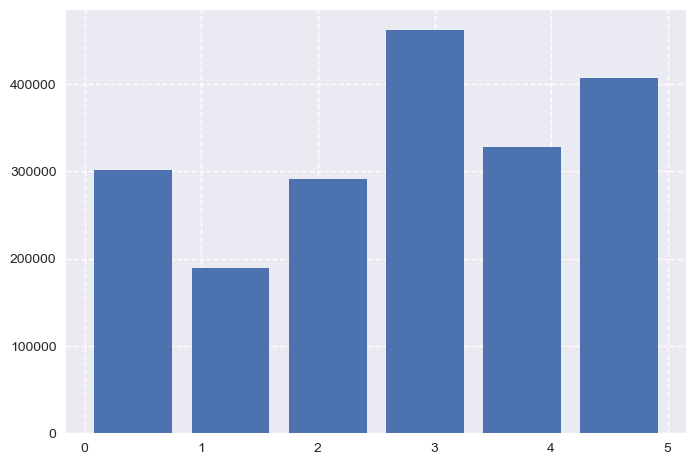

In [41]:
plt.hist(y_synthetic, bins=len(config_dict_1), rwidth=0.8);

In [42]:
fair_synth = np.sum(y_synthetic == 0)
fair_gt = np.sum(y_gt == 0)

fair_synth, fair_synth / len(y_synthetic)

(301912, 0.1525043769390623)

In [43]:
cheat_synth = int(fair_synth / 5)
cheat_gt = int(fair_gt / 5)
cheat_synth, cheat_gt

(60382, 12313)

In [44]:
def preprocess_normed_synthetic_csv(data_name):
    df = preprocess_synthetic_csv(data_name)
    if data_name != "fair":
        df = df.sample(n=cheat_synth)
        df["cheat_flag"] = 1
    return df

def preprocess_normed_gt_csv(data_name):
    df = preprocess_gt_csv(data_name)
    if data_name != "fair":
        df = df.sample(n=cheat_gt)
        df["cheat_flag"] = 1
    return df

In [45]:
synthetic_data = pd.concat([preprocess_normed_synthetic_csv(data_name) for data_name in config_dict_1.values()])

X_synthetic = synthetic_data.drop(["cheat_flag", "session_id"], axis=1)
y_synthetic = synthetic_data["cheat_flag"]

X_synthetic.shape, y_synthetic.shape

((603822, 10), (603822,))

In [46]:
gt_data_1 = pd.concat([preprocess_normed_gt_csv(data_name) for data_name in config_dict_1.values()])
gt_data_2 = pd.concat([preprocess_normed_gt_csv(data_name) for data_name in config_dict_2.values()])
gt_data = pd.concat([gt_data_1, gt_data_2])

X_gt = gt_data.drop(["cheat_flag", "session_id"], axis=1)
y_gt = gt_data["cheat_flag"]

X_gt.shape, y_gt.shape

((174977, 10), (174977,))

In [51]:
mix_num = len(X_gt) // 4

gt_idx = np.random.choice(len(X_gt), replace=False, size=mix_num)

gt_rest = [i for i in np.arange(len(X_gt)) if i not in gt_idx]

X_train_mixed = pd.concat([X_synthetic, X_gt.iloc[gt_idx]])
y_train_mixed = pd.concat([y_synthetic, y_gt.iloc[gt_idx]])

X_test = X_gt.iloc[gt_rest]
y_test = y_gt.iloc[gt_rest]

X_train_mixed.shape, y_train_mixed.shape, X_test.shape, y_test.shape

((647566, 10), (647566,), (131233, 10), (131233,))

In [52]:
train_set = TensorDataset(
    torch.FloatTensor(X_train_mixed.to_numpy()).unsqueeze(1),
    torch.LongTensor(y_train_mixed.to_numpy()),
)
train_loader = DataLoader(train_set, batch_size=6_000, shuffle=True)

test_set = TensorDataset(
    torch.FloatTensor(X_test.to_numpy()).unsqueeze(1),
    torch.LongTensor(y_test.to_numpy()),
)
test_loader = DataLoader(test_set, batch_size=6_000, shuffle=True)

In [53]:
names = [
    "Decision Tree",
    "Random Forest",
    "Gaussian Naive Bayes",
]

classifiers = [
    DecisionTreeClassifier( random_state=42),
    RandomForestClassifier(random_state=42),
    GaussianNB(),
]

In [54]:
for name, clf in zip(names, classifiers):
    print(f"{name} model:")

    train_acc = 0
    start = time.time()

    for X, y in tqdm(train_loader):
        clf.fit(X.numpy().squeeze(), y.numpy())
        train_acc += clf.score(X.numpy().squeeze(), y.numpy())

    end = time.time()
    train_acc /= len(train_loader)

    test_acc = 0
    for X, y in tqdm(test_loader):
        test_acc += clf.score(X.numpy().squeeze(), y.numpy())
    test_acc /= len(test_loader)

    # snake_case_name = "_".join(name.lower().split(" "))
    # joblib.dump(clf, f"../microservices/DataManager/weights/binary_more/{snake_case_name}.joblib")
    # print(f"Saved model.")

    print(f"Train time: {(end - start):.1f} sec,  Train score: {train_acc:.3f},  Gt score: [ {test_acc:.3f} ]")
    print("-" * 150)

Decision Tree model:


100%|██████████| 22/22 [00:00<00:00, 29.27it/s]


Train time: 8.0 sec,  Train score: 1.000,  Gt score: [ 0.825 ]
------------------------------------------------------------------------------------------------------------------------------------------------------
Random Forest model:


100%|██████████| 22/22 [00:01<00:00, 13.02it/s]


Train time: 121.2 sec,  Train score: 1.000,  Gt score: [ 0.837 ]
------------------------------------------------------------------------------------------------------------------------------------------------------
Gaussian Naive Bayes model:


100%|██████████| 22/22 [00:00<00:00, 28.66it/s]

Train time: 4.1 sec,  Train score: 0.556,  Gt score: [ 0.375 ]
------------------------------------------------------------------------------------------------------------------------------------------------------


In [29]:
input_size = 10
hidden_size = 50
output_size = 2
num_layers = 1

learning_rate = 0.001
num_epochs = 50
batch_size = 60

In [30]:
from microservices.DataManager.models.lstm import LSTMModel, LSTM2

model = LSTM2(input_size, hidden_size, output_size, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=5, threshold=1, factor=0.8, threshold_mode="abs", min_lr=0.000005, verbose=True)

/Users/alorthius/anaconda3/envs/big_data/lib/python3.10/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [31]:
for epoch in range(num_epochs):
    train_loss = 0
    train_corrects = 0

    model.train()
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels).item()

    train_loss /= len(train_loader)
    train_acc = train_corrects / len(train_set) * 100
    print(f"[ Train    {epoch + 1}/{num_epochs} ] loss: {train_loss:.4f}, accuracy: [ {train_acc:<7.4f}% ]")

    test_corrects = 0

    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            test_corrects += torch.sum(preds == labels).item()

    test_acc = test_corrects / len(test_set) * 100
    print(f"[ Gt         {epoch + 1}/{num_epochs} ], accuracy: [ {test_acc:<7.4f}% ]")

    print("-" * 150)

    scheduler.step(test_acc)

100%|██████████| 108/108 [00:06<00:00, 16.68it/s]


[ Train    1/50 ] loss: 0.6406, accuracy: [ 62.2406% ]
[ Gt         1/50 ], accuracy: [ 64.6331% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.38it/s]


[ Train    2/50 ] loss: 0.5460, accuracy: [ 71.5807% ]
[ Gt         2/50 ], accuracy: [ 69.7546% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.54it/s]


[ Train    3/50 ] loss: 0.5277, accuracy: [ 72.9638% ]
[ Gt         3/50 ], accuracy: [ 68.3837% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.11it/s]


[ Train    4/50 ] loss: 0.5302, accuracy: [ 72.3168% ]
[ Gt         4/50 ], accuracy: [ 70.8557% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.50it/s]


[ Train    5/50 ] loss: 0.5122, accuracy: [ 74.4071% ]
[ Gt         5/50 ], accuracy: [ 69.1937% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 17.02it/s]


[ Train    6/50 ] loss: 0.5049, accuracy: [ 74.8935% ]
[ Gt         6/50 ], accuracy: [ 68.6268% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 17.17it/s]


[ Train    7/50 ] loss: 0.4980, accuracy: [ 75.2885% ]
[ Gt         7/50 ], accuracy: [ 67.6316% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.56it/s]


[ Train    8/50 ] loss: 0.4791, accuracy: [ 76.4157% ]
[ Gt         8/50 ], accuracy: [ 65.6847% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.25it/s]


[ Train    9/50 ] loss: 0.4685, accuracy: [ 77.0864% ]
[ Gt         9/50 ], accuracy: [ 67.5158% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.43it/s]


[ Train    10/50 ] loss: 0.4504, accuracy: [ 78.4255% ]
[ Gt         10/50 ], accuracy: [ 65.0301% ]
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 00010: reducing learning rate of group 0 to 8.0000e-04.


100%|██████████| 108/108 [00:06<00:00, 16.37it/s]


[ Train    11/50 ] loss: 0.4328, accuracy: [ 79.5689% ]
[ Gt         11/50 ], accuracy: [ 66.9412% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.64it/s]


[ Train    12/50 ] loss: 0.4231, accuracy: [ 79.9986% ]
[ Gt         12/50 ], accuracy: [ 66.4261% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.63it/s]


[ Train    13/50 ] loss: 0.4245, accuracy: [ 79.4575% ]
[ Gt         13/50 ], accuracy: [ 66.0413% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.30it/s]


[ Train    14/50 ] loss: 0.4075, accuracy: [ 80.4465% ]
[ Gt         14/50 ], accuracy: [ 64.8153% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.53it/s]


[ Train    15/50 ] loss: 0.4427, accuracy: [ 78.8174% ]
[ Gt         15/50 ], accuracy: [ 61.8107% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.47it/s]


[ Train    16/50 ] loss: 0.4572, accuracy: [ 78.7319% ]
[ Gt         16/50 ], accuracy: [ 64.8937% ]
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 00016: reducing learning rate of group 0 to 6.4000e-04.


100%|██████████| 108/108 [00:06<00:00, 15.56it/s]


[ Train    17/50 ] loss: 0.4234, accuracy: [ 80.0596% ]
[ Gt         17/50 ], accuracy: [ 67.2361% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:07<00:00, 14.89it/s]


[ Train    18/50 ] loss: 0.4147, accuracy: [ 80.2931% ]
[ Gt         18/50 ], accuracy: [ 65.2351% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.61it/s]


[ Train    19/50 ] loss: 0.4069, accuracy: [ 80.2697% ]
[ Gt         19/50 ], accuracy: [ 66.7995% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.41it/s]


[ Train    20/50 ] loss: 0.3952, accuracy: [ 80.8526% ]
[ Gt         20/50 ], accuracy: [ 64.6552% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.84it/s]


[ Train    21/50 ] loss: 0.3873, accuracy: [ 80.8134% ]
[ Gt         21/50 ], accuracy: [ 66.8239% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 17.03it/s]


[ Train    22/50 ] loss: 0.3787, accuracy: [ 81.0455% ]
[ Gt         22/50 ], accuracy: [ 64.6217% ]
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 00022: reducing learning rate of group 0 to 5.1200e-04.


100%|██████████| 108/108 [00:06<00:00, 16.81it/s]


[ Train    23/50 ] loss: 0.3729, accuracy: [ 81.2444% ]
[ Gt         23/50 ], accuracy: [ 64.9021% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.02it/s]


[ Train    24/50 ] loss: 0.3674, accuracy: [ 81.5813% ]
[ Gt         24/50 ], accuracy: [ 65.4919% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.57it/s]


[ Train    25/50 ] loss: 0.3636, accuracy: [ 81.6306% ]
[ Gt         25/50 ], accuracy: [ 67.8640% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.56it/s]


[ Train    26/50 ] loss: 0.3600, accuracy: [ 81.7299% ]
[ Gt         26/50 ], accuracy: [ 67.5882% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.88it/s]


[ Train    27/50 ] loss: 0.3568, accuracy: [ 81.9393% ]
[ Gt         27/50 ], accuracy: [ 68.3136% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.89it/s]


[ Train    28/50 ] loss: 0.3519, accuracy: [ 82.1797% ]
[ Gt         28/50 ], accuracy: [ 67.0243% ]
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 00028: reducing learning rate of group 0 to 4.0960e-04.


100%|██████████| 108/108 [00:06<00:00, 16.74it/s]


[ Train    29/50 ] loss: 0.3435, accuracy: [ 82.7360% ]
[ Gt         29/50 ], accuracy: [ 68.2778% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.92it/s]


[ Train    30/50 ] loss: 0.3411, accuracy: [ 82.9112% ]
[ Gt         30/50 ], accuracy: [ 68.8463% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.82it/s]


[ Train    31/50 ] loss: 0.3365, accuracy: [ 83.1429% ]
[ Gt         31/50 ], accuracy: [ 67.9951% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.84it/s]


[ Train    32/50 ] loss: 0.3353, accuracy: [ 83.1333% ]
[ Gt         32/50 ], accuracy: [ 69.7698% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 15.79it/s]


[ Train    33/50 ] loss: 0.3336, accuracy: [ 83.2417% ]
[ Gt         33/50 ], accuracy: [ 70.1020% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.24it/s]


[ Train    34/50 ] loss: 0.3294, accuracy: [ 83.4618% ]
[ Gt         34/50 ], accuracy: [ 68.1193% ]
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 00034: reducing learning rate of group 0 to 3.2768e-04.


100%|██████████| 108/108 [00:06<00:00, 16.39it/s]


[ Train    35/50 ] loss: 0.3263, accuracy: [ 83.5502% ]
[ Gt         35/50 ], accuracy: [ 70.0243% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.76it/s]


[ Train    36/50 ] loss: 0.3252, accuracy: [ 83.6815% ]
[ Gt         36/50 ], accuracy: [ 70.4312% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.64it/s]


[ Train    37/50 ] loss: 0.3250, accuracy: [ 84.0103% ]
[ Gt         37/50 ], accuracy: [ 71.6268% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.89it/s]


[ Train    38/50 ] loss: 0.3225, accuracy: [ 84.4498% ]
[ Gt         38/50 ], accuracy: [ 72.7424% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.83it/s]


[ Train    39/50 ] loss: 0.3206, accuracy: [ 84.6082% ]
[ Gt         39/50 ], accuracy: [ 72.3499% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.48it/s]


[ Train    40/50 ] loss: 0.3184, accuracy: [ 84.8397% ]
[ Gt         40/50 ], accuracy: [ 74.3814% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 17.27it/s]


[ Train    41/50 ] loss: 0.3163, accuracy: [ 85.0522% ]
[ Gt         41/50 ], accuracy: [ 73.6019% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.61it/s]


[ Train    42/50 ] loss: 0.3148, accuracy: [ 85.1509% ]
[ Gt         42/50 ], accuracy: [ 72.6045% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 17.02it/s]


[ Train    43/50 ] loss: 0.3130, accuracy: [ 85.2656% ]
[ Gt         43/50 ], accuracy: [ 73.8534% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.64it/s]


[ Train    44/50 ] loss: 0.3118, accuracy: [ 85.2993% ]
[ Gt         44/50 ], accuracy: [ 74.1521% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.82it/s]


[ Train    45/50 ] loss: 0.3105, accuracy: [ 85.4080% ]
[ Gt         45/50 ], accuracy: [ 73.6187% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.79it/s]


[ Train    46/50 ] loss: 0.3097, accuracy: [ 85.4234% ]
[ Gt         46/50 ], accuracy: [ 74.5857% ]
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 00046: reducing learning rate of group 0 to 2.6214e-04.


100%|██████████| 108/108 [00:06<00:00, 16.70it/s]


[ Train    47/50 ] loss: 0.3060, accuracy: [ 85.6205% ]
[ Gt         47/50 ], accuracy: [ 74.0568% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.84it/s]


[ Train    48/50 ] loss: 0.3052, accuracy: [ 85.6651% ]
[ Gt         48/50 ], accuracy: [ 74.4066% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.65it/s]


[ Train    49/50 ] loss: 0.3046, accuracy: [ 85.7022% ]
[ Gt         49/50 ], accuracy: [ 74.3052% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 108/108 [00:06<00:00, 16.85it/s]


[ Train    50/50 ] loss: 0.3043, accuracy: [ 85.7602% ]
[ Gt         50/50 ], accuracy: [ 74.4089% ]
------------------------------------------------------------------------------------------------------------------------------------------------------


In [32]:
torch.save(model.state_dict(), f"../microservices/DataManager/weights/binary_more/lstm.pth")